# TOV Emulator to train a NN to predict just RADIUS of a Neutron Star from a Neuclear EOS

### <div style= 'color: goldenrod'> Import all the required modules

In [2]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

import numpy as np
import matplotlib.pyplot as plt
from numpy import pi as pi
from scipy.integrate import odeint
import torch
import torch.nn as nn
import torch.optim as optim
import time # to meaasure execution time of code blocks
from torch.utils.data import TensorDataset, DataLoader


# Custom modules
import eos # generates EOS tables. Returns energy density, pressure, etc. for given set of EOS parameters. 
import tov # solves TOV equations and returns mass and radius for a given EOS and central pressure
import tov_tide # solves TOV equations including tidal deformability calculations, for neutron star tidal effects in binaries.


%matplotlib widget

### <div style= 'color: goldenrod'> Define the following functions:
$EoS(\theta)$:
Generate the energy density and pressure arrays for a given EOS parameter set.

$find\_first\_maxima$:
Find first local maxima (to get NS mass)

$get\_MR\_pc$:
Solve TOV equations to get mass-radius points for an array of central pressures.

$get\_MRL\_pc$:
Solve TOV equations to get mass, radius and tidal deformability points for an array of central pressures.

In [3]:
dkm = 1.3234e-6 # conversion of energy density and pressure from Mev/fm^3 to km^-2
conv = 197.33**3 # MeV/fm3 is roughly h_bar * c in natural units
pcmin = 1.33e-6 # Fiducial minimum central pressure used when generating neutron star sequences
                # Ensures TOV solver starts with a non-zero pressure 


def EoS(θ):
    """
    Generate the energy density and pressure arrays for a given EOS parameter set.
    Returns Energy and pressure array given given eos parameters and if eos is not montonic returns nan.
    
    Parameters:
    ----------
    θ = [L0, Ksym]: parameters of the nuclear EOS.
            
            L0: slope of symmetry energy. Controls how neutron-rich matter pressure grows with density.
            Ksym: curvature of symmetry energy. Determines how “stiff” the EOS is for neutron-rich matter at higher densities.
    
    Returns:
    -------
    nb: baryon number density array
    ener: energy density at each density point array
    pres: pressure at each density point array
    cs: speed of sound array
    icc: flag if EOS is causal or monotonic

    """
    L0, Ksym = θ[0], θ[1]
    # Calling the eos.eos module
    index, nb, pressure, energy, cs, icc = eos.eos(L0, Ksym, 1.6, 3.0, 6.2, 3.7, 2.4, 2.6)
    # Truncate arrays up to index-1 to ensure valid, monotonic EOS.
    nb = nb[0:index-1] 
    pressure = pressure[0:index-1]
    energy = energy[0:index-1]
    cs = cs[0:index-1]
    # Converts pressure and energy to km^-2 units
    pres = pressure * dkm
    ener = energy * dkm
    return ener, pres, nb, cs, icc

################################################################################

def get_MR_pc(θ, pc):
    """
    Solve TOV equations to get mass-radius points for an array of central pressures.

    Parameters:
    ----------
    θ: [L0, Ksym] EOS parameters
    pc: array of entral pressures

    Returns:
    -------
    M: List of Masses
    R: List of Radiuses corresponding to each central pressure

    """
    M=[]
    R=[]
    for i in pc:
        L0, Ksym = θ[0], θ[1]
        # Calling the eos.eos module
        index, nb, pressure, energy, cs, icc = eos.eos(L0, Ksym, 1.6, 3.0, 6.2, 3.7, 2.4, 2.6)
        pressure = pressure[0:index-1]
        energy = energy[0:index-1]
        pres = pressure * dkm
        ener = energy * dkm
        # Calling the tov.tov module
        m, r = tov.tov(ener, pres, [i])
        M.append(m)
        R.append(r)
    return M, R
    
################################################################################

def get_MRL_pc(θ, pc):
    """
    Solve TOV equations to get mass, radius and tidal deformability points for an array of central pressures.

    Parameters:
    ----------
    θ: [L0, Ksym] EOS parameters
    pc: array of central pressures

    Returns:
    -------
    M: List of Masses
    R: List of Radiuses 
    L: List of Tidal deformabilities corresponding to each central pressure
    """
    M=[]
    R=[]
    L=[]
    for i in pc:
        L0, Ksym = θ[0] ,θ[1]
        # Calling the eos.eos module
        index, nb, pressure, energy, cs, icc = eos.eos(L0, Ksym, 1.6, 3.0, 6.2, 3.7, 2.4, 2.6)
        pressure = pressure[0:index-1]
        energy = energy[0:index-1]
        pres = pressure * dkm
        ener = energy * dkm
        # Calling the tov_tide.tov_tide module
        m, r, td = tov_tide.tov_tide(ener, pres, [i])
        M.append(m)
        R.append(r)
        L.append(td)
    return M, R, L

################################################################################

def find_first_maxima(arr):
    """
    Identify the first peak in a 1D array (used to find maximum neutron star mass).
    Loops through array to check if an element is larger than its neighbors → first local maximum.
    If no local maxima found, returns global maximum as fallback.

    Parameters:
    ----------
    arr: mass array

    Returns:
    -------
    max_index: index of the first maxima
    arr[max_index]: mass value of the first maxima

    """
    for i in range(1, len(arr) - 1):
        if arr[i] > arr[i - 1] and arr[i] > arr[i + 1]:
            return i, arr[i]  # Return the index and the value of the first maxima
    max_index = np.argmax(arr)
    return max_index, arr[max_index]

### <div style= 'color: yellow'> Load the generated dataset, normalizing it and splitting into training and validation datasets

In [40]:
import pandas as pd
import re

num_samples = 1000 #############################################################

# Load dataset saved with np.savez
dataset_name = f"EOS_dataset_{num_samples}samples.npz"
dataset_loc = "/home/kay/ML-for-Neutron-Stars/COMMA_emulator/Outputs-Kay/Datasets/"
data = np.load(dataset_loc+dataset_name)

# Extract columns
log_pc_samples = data['log_pc_samples']     # shape: (N,)
valid_EOS_params = data['valid_EOS_params'] # shape: (N, 2)
MRL_data = data['MRL_data']                 # shape: (N, 3)

# Visualizing the dataset
df = pd.DataFrame(
    np.column_stack([log_pc_samples, valid_EOS_params, MRL_data]),
    columns=["log_pc", "L", "Ksym", "Mass", "Radius", "TidalDeformability"]
)
n = int(re.search(r"\d+", dataset_name).group())
print(f"Dataset preview with {n} samples:")
print(df.head(10))  # nicely formatted table of the first 10 values

# Prepare X (features) and y (targets)
X_eos = torch.tensor(np.column_stack([log_pc_samples, valid_EOS_params]), dtype=torch.float32)  # pc, L, Ksym
y_eos = torch.tensor(MRL_data[ : , 1:2], dtype=torch.float32)  # Radius (target)
print(y_eos)

# Shuffle the dataset
indices = torch.randperm(len(X_eos))
train_size = int(0.8 * len(X_eos))
train_idx = indices[:train_size]
val_idx = indices[train_size:]

# Split into training and validation sets
X_eos_train, X_eos_val = X_eos[train_idx], X_eos[val_idx]
y_eos_train, y_eos_val = y_eos[train_idx], y_eos[val_idx]

# Compute mean and std on training set only
X_eos_mean, X_eos_std = X_eos_train.mean(dim=0), X_eos_train.std(dim=0)
y_eos_mean, y_eos_std = y_eos_train.mean(dim=0), y_eos_train.std(dim=0)
 
# Normalize using training statistics
X_eos_train_norm = (X_eos_train - X_eos_mean) / X_eos_std
X_eos_val_norm   = (X_eos_val   - X_eos_mean) / X_eos_std

y_eos_train_norm = (y_eos_train - y_eos_mean) / y_eos_std
y_eos_val_norm   = (y_eos_val   - y_eos_mean) / y_eos_std

# Reshape for DataLoader
X_eos_train_norm, y_eos_train_norm = X_eos_train_norm.view(-1, 3), y_eos_train_norm.view(-1, 1)
X_eos_val_norm, y_eos_val_norm   = X_eos_val_norm.view(-1, 3), y_eos_val_norm.view(-1, 1)

# Print training ranges for logging
print(f"Training log_pc range: {X_eos_train[:,0].min().item():.4f} to {X_eos_train[:,0].max().item():.4f}")
print(f"Training L range: {X_eos_train[:,1].min().item():.4f} to {X_eos_train[:,1].max().item():.4f}")
print(f"Training Ksym range: {X_eos_train[:,2].min().item():.4f} to {X_eos_train[:,2].max().item():.4f}")


Dataset preview with 1000 samples:
     log_pc          L       Ksym      Mass     Radius  TidalDeformability
0 -5.876148  58.694477  10.576015  0.098653  69.920286        3.214959e+09
1 -5.814806  58.694477  10.576015  0.105419  45.475846        3.927776e+08
2 -5.753463  58.694477  10.576015  0.114403  33.544300        1.194948e+08
3 -5.692121  58.694477  10.576015  0.125518  26.768894        5.534953e+07
4 -5.630778  58.694477  10.576015  0.138802  22.545374        2.997355e+07
5 -5.569436  58.694477  10.576015  0.154310  19.748377        1.727188e+07
6 -5.508093  58.694477  10.576015  0.172184  17.809922        1.022104e+07
7 -5.446751  58.694477  10.576015  0.192556  16.425164        6.129059e+06
8 -5.385408  58.694477  10.576015  0.215581  15.414005        3.716365e+06
9 -5.324065  58.694477  10.576015  0.241471  14.664074        2.263645e+06
tensor([[69.9203],
        [45.4758],
        [33.5443],
        ...,
        [11.3878],
        [11.2384],
        [11.0829]])
Training log

In [41]:
print(X_eos_train_norm.mean(), X_eos_train_norm.std())
print(y_eos_train_norm.mean(), y_eos_train_norm.std())
print(X_eos_val_norm.mean(), X_eos_val_norm.std())
print(y_eos_val_norm.mean(), y_eos_val_norm.std())


tensor(2.7815e-08) tensor(1.0000)
tensor(-5.8464e-08) tensor(1.)
tensor(0.0041) tensor(1.0035)
tensor(-0.0091) tensor(0.9500)


### <div style= 'color: yellow'> Defining and training the NN

In [42]:
# Set model number for saving
Model_num = "Radius_Model4" ###########################################################

In [43]:
# Define Neural Network for EOS predictions
class HybridPP_EOS_NN(nn.Module):
    def __init__(self, input_dim=3, hidden_dim=50, output_dim=1):
        super(HybridPP_EOS_NN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
        # self.dropout = nn.Dropout(p=0.1) # Dropout layer for regularization

    def forward(self, x):
        x = self.relu(self.fc1(x))
        # x = self.dropout(x)
        x = self.relu(self.fc2(x))
        # x = self.dropout(x)
        return self.fc3(x)

Epoch [100/5000],
              Training Loss: 0.6692,
              Validation Loss: 0.5918
Epoch [200/5000],
              Training Loss: 0.4646,
              Validation Loss: 0.4065
Epoch [300/5000],
              Training Loss: 0.3107,
              Validation Loss: 0.2746
Epoch [400/5000],
              Training Loss: 0.2084,
              Validation Loss: 0.1911
Epoch [500/5000],
              Training Loss: 0.1454,
              Validation Loss: 0.1393
Epoch [600/5000],
              Training Loss: 0.1052,
              Validation Loss: 0.1058
Epoch [700/5000],
              Training Loss: 0.0771,
              Validation Loss: 0.0821
Epoch [800/5000],
              Training Loss: 0.0572,
              Validation Loss: 0.0655
Epoch [900/5000],
              Training Loss: 0.0433,
              Validation Loss: 0.0536
Epoch [1000/5000],
              Training Loss: 0.0335,
              Validation Loss: 0.0460
Epoch [1100/5000],
              Training Loss: 0.0261,
             

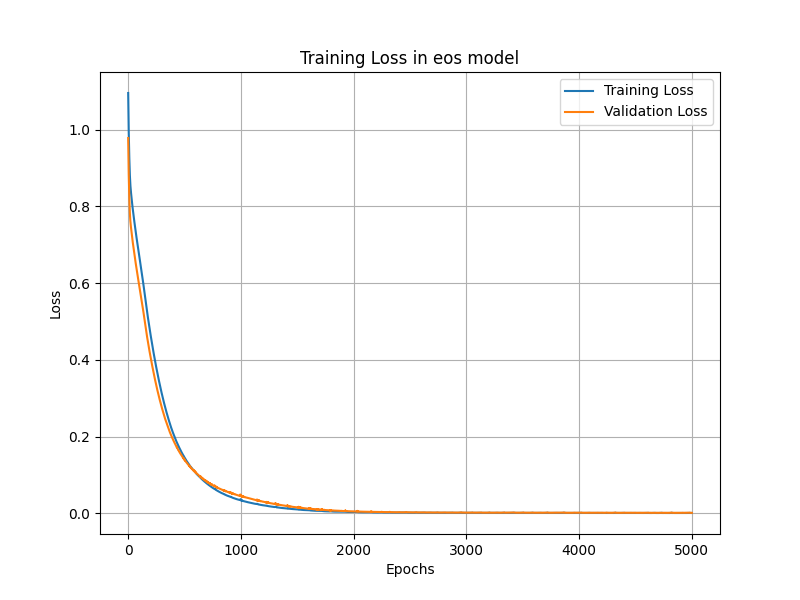

In [45]:
# Initialize and train the model
model_eos = HybridPP_EOS_NN()
criterion = nn.MSELoss()
optimizer = optim.Adam(model_eos.parameters(), lr=0.001) 
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=10)

start_time = time.time()

epochs = 5000 #################################################################
training_losses = []
val_losses = []

# best_val_loss = float('inf')
# patience = 100  # Number of epochs to wait for improvement before stopping
# patience_counter = 0

# Without batching (original code)
for epoch in range(epochs):
    # Training
    model_eos.train() # Training mode
    optimizer.zero_grad() # Erase the record of gradients
    outputs = model_eos(X_eos_train_norm) # Forward pass
    loss = criterion(outputs, y_eos_train_norm) # Compute training loss
    loss.backward() # Backward propogate the training loss
    optimizer.step()
    # scheduler.step(loss) # Adjust learning rate based on validation loss
    training_losses.append(loss.item())

    # Validation
    model_eos.eval() # Validation mode
    with torch.no_grad():
        val_outputs = model_eos(X_eos_val_norm)
        val_loss = criterion(val_outputs, y_eos_val_norm)
        val_losses.append(val_loss.item())

    # # Early stopping check
    # if val_loss.item() < best_val_loss:
    #     best_val_loss = val_loss.item()
    #     patience_counter = 0
    #     # Save the best model weights
    #     best_model_state = model_eos.state_dict()
    # else:
    #     patience_counter += 1
    #     if patience_counter >= patience:
    #         print(f"Early stopping at epoch {epoch+1}")
    #         break

    # Print progress every 100 epochs
    if (epoch + 1) % 100 == 0: 
        print(f"""Epoch [{epoch + 1}/{epochs}],
              Training Loss: {loss.item():.4f},
              Validation Loss: {val_loss.item():.4f}""")

end_time = time.time()
training_time = end_time - start_time

# # Restore best model
# model_eos.load_state_dict(best_model_state)
# print(f"Training finished. Best validation loss: {best_val_loss:.4f}")

# Plot Training Loss
plt.figure(figsize=(8, 6))
plt.plot(training_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training Loss in eos model")
plt.grid()

fig_loc = "/home/kay/ML-for-Neutron-Stars/COMMA_emulator/Outputs-Kay/Radius_Models/"
fig_name = f"{Model_num}_Losses.png"
plt.savefig(fig_loc+fig_name, dpi=300, bbox_inches='tight')

plt.show()

### <div style= 'color: goldenrod'> Save trained model

In [30]:
# Save trained model
network_loc = "/home/kay/ML-for-Neutron-Stars/COMMA_emulator/Outputs-Kay/Radius_Models/"
network_name = f"{Model_num}_hybridPP_nn.pth"
torch.save(model_eos.state_dict(), network_loc+network_name)

### <div style= 'color: goldenrod'> Save model details to a text file

In [31]:
file_loc = "/home/kay/ML-for-Neutron-Stars/COMMA_emulator/Outputs-Kay/Radius_Models/"
file_name = Model_num+"_details.txt"

with open(file_loc + file_name, "w") as f:
    f.write(f"{Model_num} DETAILS\n\n")
    f.write("Number of dimensions:\n")
    f.write(f"input_dims: {model_eos.fc1.in_features}\n")
    f.write(f"hidden_dims: {model_eos.fc1.out_features}\n")
    f.write(f"output_dims: {model_eos.fc3.out_features}\n\n")
    f.write(f"Number of Hidden Layers: {len(list(model_eos.children()))//2}\n")
    f.write(f"Number of samples: {num_samples}\n\n")
    f.write(f"epochs: {epochs}\n\n")
    # f.write(f"delta of criterion: {criterion.delta}\n\n")
    f.write(f"optimizer: Adam\n\n")
    f.write(f"learning rate: {optimizer.param_groups[0]['lr']}\n\n")
    f.write(f"Training stopped at epoch: {epoch+1}\n")
    f.write(f"training_time_seconds: {training_time:.2f}\n")
    # f.write(f"Best validation loss: {best_val_loss:.4f}\n\n")

### <div style= 'color: yellow'>Model Evaluation and comparison on Testing (unseen) data

log_pc range: -5.8761 to -3.3880
log_pc range: -5.8761 to -3.1562
log_pc range: -5.8761 to -3.2249
log_pc range: -5.8761 to -3.1271
log_pc range: -5.8761 to -3.2457
log_pc range: -5.8761 to -3.2607
log_pc range: -5.8761 to -3.1590
log_pc range: -5.8761 to -3.2760
log_pc range: -5.8761 to -3.2884


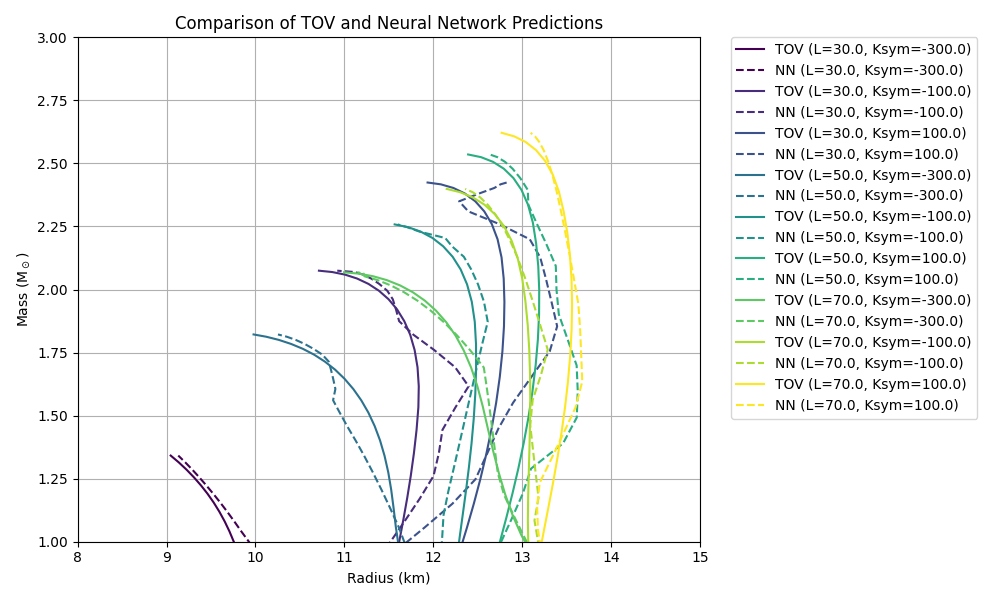

In [ ]:
num_points = 50
# Prepare ranges for L and Ksym
L_values = [30., 50., 70.]  
Ksym_values = [-300., -100., 100.]  

# Initialize lists to store results
predicted_radius = []
original_mass = []
original_radius = []

model_eos.eval() # Set model to evaluation mode

# Iterate over all L and Ksym values
for L in L_values:
    for Ksym in Ksym_values:
        ee, pp, nb, cs, icc = EoS([L, Ksym])
        # Check conditions
        if icc == 0 and max(pp) > pcmin:
            # Create pressure grid
            pc_array = np.logspace(np.log10(pcmin), np.log10(max(pp)), num_points)
            
            # Calculate original mass and radius using TOV
            M_orig, R_orig = get_MR_pc([L, Ksym], pc_array)

            # Convert to NumPy arrays for element-wise operations
            M_orig = np.array(M_orig)
            R_orig = np.array(R_orig)

            # Find first maxima in mass array
            j, mmax = find_first_maxima(M_orig) # mmax is the maximum mass
        
            # Slice and convert to log10
            pc_array = pc_array[:j]
            log_pc_array = np.log10(pc_array)
            M_orig = M_orig[:j]
            R_orig = R_orig[:j]

            # Prepare input for each pc point: [log_pc, L, Ksym]
            input_array = np.column_stack([
                            log_pc_array,
                            np.full_like(log_pc_array, L),
                                np.full_like(log_pc_array, Ksym)
                                            ])
            
            input_tensor = torch.tensor(input_array, dtype=torch.float32)
            
            # Normalize the input data using the training mean and std
            input_norm = (input_tensor - X_eos_mean) / X_eos_std
            
            # Make predictions with the trained model
            with torch.no_grad():  
                prediction = model_eos(input_norm)
            
            # Convert the prediction tensor to NumPy and denormalize the predicted mass and radius
            # Get all predictions
            prediction_np = prediction.detach().numpy()  # shape: (N, 2)
            # Denormalize each column
            radius_pred = prediction_np[:, 0] * y_eos_std[0].item() + y_eos_mean[0].item()

            # After iterating over pc, store the results for each kappa, gamma pair
            predicted_radius.append(radius_pred)
            original_mass.append(M_orig)
            original_radius.append(R_orig)

plt.figure(figsize=(10, 6))

# Create a color map
colors = plt.cm.viridis(np.linspace(0, 1, len(L_values) * len(Ksym_values)))

# Iterate and assign the same color to TOV and NN prediction
for i, (L, Ksym) in enumerate([(k, g) for k in L_values for g in Ksym_values]):
    color = colors[i]
    plt.plot(original_radius[i], original_mass[i], label=f"TOV (L={L}, Ksym={Ksym})", linestyle='-', color=color)
    plt.plot(predicted_radius[i], original_mass[i], label=f"NN (L={L}, Ksym={Ksym})", linestyle='--', color=color)

plt.xlabel("Radius (km)")
plt.ylabel("Mass (M$_\odot$)")
plt.xlim(8, 15)
plt.ylim(1, 3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.title("Comparison of TOV and Neural Network Predictions")
plt.grid()
plt.tight_layout()

fig_loc = "/home/kay/ML-for-Neutron-Stars/COMMA_emulator/Outputs-Kay/Radius_Models/"
fig_name = f"{Model_num}_Testing_accuracy.png"
plt.savefig(fig_loc+fig_name, dpi=300, bbox_inches='tight')

plt.show()

In [34]:
print("Training log_pc range:", X_eos_train[:,0].min().item(), X_eos_train[:,0].max().item())
print("Inference log_pc range:", input_tensor[:,0].min().item(), input_tensor[:,0].max().item())


Training log_pc range: -5.876148223876953 -3.0106425285339355
Inference log_pc range: -5.876148223876953 -3.288433790206909


In [50]:
print("y_eos_mean, y_eos_std:", y_eos_mean, y_eos_std[0].item())


y_eos_mean, y_eos_std: tensor([17.0030]) 19.658966064453125
